Recreation of the Aeonium2.0.R script I wrote at LMU.

This script:

1) Calculated free acid (FA) of various Aeonium plants in order to assess the strength of the CAM response under a variety of different climatic conditions.

2) Separated FA by morning and evening results.

3) Calculated the absolute difference between morning and night FA for each sample

4) Calculated the relative difference between morning and night FA for each sample

Packages used (R): Tidyverse 

In [ ]:
#Importing packages for analysis
import pandas as pd #pandas is a Python library (py terminology for package) whihc can help with data analysis, cleaning, manipulating and exploration
import matplotlib.pyplot as plt #matplotlib is a library for creating various visualisations
import seaborn as sns #assists in the creation of attractive and informative statistical graphs
import os #provides functions for interacting with the operating system

In [ ]:
#Setting the working directory
os.chdir("/home/joe/Desktop/Coding/Python/Thibaud_Project")
os.getcwd() #check if wd properly set, note this doesn't output within this jupyter cell for some reason


In [ ]:
#Load in the Aeonium data set 
Aeonium = pd.read_csv("TitrationAeonium.csv")  #read the csv
print(Aeonium.info()) #viewing the variables and data within our .csv, remove ".info()" to view data in its entirety 

Unlike the Pelargonium dataset, there is some previously collected Aeonium data... which has already been calculated as averages but does not contain data of specific samples.

This means the data I collected myself (at timepoint III) is in a different format.

So I want to:

1) Filter Aeonium timepoints I and II separately from Aeonium III
2) Calculate Aeonium III averages 
3) Filter Aeonium I and II data to have the same columns as Aeonium III 
4) Merge the data, allowing us to use the whole data together.

The following code was used to do this in R:

Aeonium_I_II <- Aeonium %>% filter(is.na(FA))
Aeonium_III <- Aeonium %>% filter(is.na(average_FA))

Aeonium_III_average <- aggregate(FA ~ timepoint + species + species_treatment + time_of_day + replicate, Aeonium, mean)
Aeonium_III_average <- rename(Aeonium_III_average, average_FA = FA)

In [ ]:
#Filtering Aeonium I and II 
Aeonium_I_II = Aeonium[Aeonium['FA'].isna()] #Filters data which has no entries for FA
Aeonium_III = Aeonium[Aeonium['average_FA'].isna()] #Filters data with no average_FA entries

#check if data filtered successfully
print(Aeonium_I_II["FA"])
print(Aeonium_III["average_FA"])

In [ ]:
#Calculate average_FA for Aeonium_III species
Aeonium_III_average = Aeonium_III.groupby(['timepoint', 'species', 'species_treatment', 'time_of_day', 'replicate'])['FA'].mean().reset_index() #equivalent to aggregate in R
Aeonium_III_average = Aeonium_III_average.rename(columns={'FA': 'average_FA'})
print(Aeonium_III_average[["species_treatment","average_FA"]]) #check if calculations look good

In [ ]:
#Filter Aeonium_I_II to have same columns as Aeonium_III_average 
Aeonium_I_II_average = Aeonium_I_II[['timepoint', 'species_treatment', 'time_of_day', 'replicate', 'average_FA', 'species']]

#Combine the two 
Aeonium_merge = pd.concat([Aeonium_III_average, Aeonium_I_II_average], ignore_index=True)

In [ ]:
#Free acid calculation
Aeonium["FA"] = ((0.00001 * Aeonium["VNaOH"] / 1000) * 3.5) / (Aeonium["FW"] / 1000) * 1000000
print(Aeonium.info()) #check if 'FA' column successfully added to the code

#Note that this calculation was done in .csv already, redoing it here is not required (but I prefer to calculate in here as it's easier to add new data)

Now we have that done, the next step is:

1) Calculate the absolute and percentage differences of morning/night, as well as their sd
    Note: Pelargonium datasets did not have enough replicates for sd calculations.

2) Combine the sd and differences into a new dataframe suitable for data visualisation

3) Filter dataset to produce suitable graphs for each species 

In [ ]:
#Prepare differnces datasets into morning and evening
Aeonium_difference = Aeonium_merge.groupby(['species_treatment','timepoint', 'species',  'time_of_day'])['average_FA'].mean().reset_index()

Aeonium_morning_difference = Aeonium_difference[Aeonium_difference['time_of_day'] == 'morning']
Aeonium_evening_difference = Aeonium_difference[Aeonium_difference['time_of_day'] == 'evening']

print(Aeonium_morning_difference[["average_FA"]])
print(Aeonium_evening_difference[["timepoint"]])

In [ ]:
#Equivalent functions in R worked without further modification... but I believe A. percaneum (warm-control) only existing at timepoint III in morning samples prevents this working in python
#Also note that I chose to sort by species_treatment first when grouping, this was to keep the same row order as my R script


print(Aeonium_morning_difference.iloc[73]) #this is my target of removal, as rows start at "0" in python it is one less than its position in R (74)

#Specify the removal of rows with the values of A. percaneum (warm-control) AND 3.0 for species_treatment and timepoint respectively
Aeonium_morning_difference = Aeonium_morning_difference.loc[~((Aeonium_morning_difference['species_treatment'] == "A. percaneum (warm-control)") & (Aeonium_morning_difference['timepoint'] == 3.0))]

#the ~ negates the entire boolean mask as selected, removing the rows.. removal of this ~ will instead filter everything BUT the variables chosen

#now filtering is done... hopefully we can continue smoothly

print(Aeonium_morning_difference[["average_FA"]])
print(Aeonium_evening_difference[["timepoint"]])

#both should have equal rows now... 

#But actually it's best to just have filtered Aeonium_merge directly in the first place
Aeonium_merge = Aeonium_merge.loc[~((Aeonium_merge['species_treatment'] == "A. percaneum (warm-control)") & (Aeonium_merge['timepoint'] == 3.0) & (Aeonium_merge['time_of_day'] == "morning"))]

#Anyway, now it is time for some difference calculations

# Calculate absolute and percentage differences
Aeonium_difference_calculations = Aeonium_morning_difference.copy()
Aeonium_difference_calculations['absolute_difference'] = Aeonium_morning_difference['average_FA'] - Aeonium_evening_difference['average_FA']
Aeonium_difference_calculations['percentage_difference'] = ((Aeonium_morning_difference['average_FA'] - Aeonium_evening_difference['average_FA']) / Aeonium_evening_difference['average_FA']) * 100

# Rejoin the evening data to the morning for average_FA plots
Aeonium_differences = pd.concat([Aeonium_difference_calculations, Aeonium_evening_difference])


In [ ]:
# Standard deviation calculations
Aeonium_sd = Aeonium_merge.groupby(['species_treatment', 'species', 'timepoint', 'time_of_day', 'replicate'])['average_FA'].mean().reset_index()

Aeonium_morning_sd = Aeonium_sd[Aeonium_sd['time_of_day'] == 'morning']
Aeonium_evening_sd = Aeonium_sd[Aeonium_sd['time_of_day'] == 'evening']
Aeonium_morning_sd.reset_index(drop=True, inplace=True)
Aeonium_evening_sd.reset_index(drop=True, inplace=True) #this resets the index order of both dataframes 

Aeonium_sd_calculations = Aeonium_morning_sd.copy()
Aeonium_sd_calculations['absolute_difference'] = Aeonium_morning_sd['average_FA'] - Aeonium_evening_sd['average_FA']
Aeonium_sd_calculations['percentage_difference'] = ((Aeonium_morning_sd['average_FA'] - Aeonium_evening_sd['average_FA']) / Aeonium_evening_sd['average_FA']) * 100

Aeonium_sd_calculations = pd.concat([Aeonium_sd_calculations, Aeonium_evening_sd])
print(Aeonium_sd_calculations[["absolute_difference"]]) 

Aeonium_sd_calculations['absolute_sd'] = Aeonium_sd_calculations.groupby(['species_treatment', 'timepoint'])['absolute_difference'].transform('std')
Aeonium_sd_calculations['percentage_sd'] = Aeonium_sd_calculations.groupby(['species_treatment', 'timepoint'])['percentage_difference'].transform('std')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(Aeonium_sd_calculations[["absolute_sd", "percentage_sd"]]) 



In [ ]:
#Ok, looks like I've finally got the SD working 
#Now the next step is to filter the Aeonium_sd_calculations to morning only 
Aeonium_sd_calculations['time_of_day'] = "morning" 
 
# Combine the sd and percentage difference calculations
Aeonium_graphs = pd.concat([Aeonium_sd_calculations, Aeonium_differences], ignore_index=True)

# Print the resulting dataframe
print(Aeonium_graphs.info())

In [ ]:
# Filter by species, to produce species-specific graphs... I think there must a be a way to produce unique graphs for each in less code... but this works regardless.
Aeonium_cana = Aeonium_graphs[Aeonium_graphs['species'] == "A. canariense ssp. canariense"]
print(Aeonium_cana)
Aeonium_chr = Aeonium_graphs[Aeonium_graphs['species'] == "A. canariense ssp. christii"]
Aeonium_cun = Aeonium_graphs[Aeonium_graphs['species'] == "A. cuneatum"]
Aeonium_dav = Aeonium_graphs[Aeonium_graphs['species'] == "A. davidbramwellii"]
Aeonium_gor = Aeonium_graphs[Aeonium_graphs['species'] == "A. gorgoneum"]
Aeonium_leu = Aeonium_graphs[Aeonium_graphs['species'] == "A. leucoblepharum"]
Aeonium_per = Aeonium_graphs[Aeonium_graphs['species'] == "A. percaneum"]
Aeonium_stu = Aeonium_graphs[Aeonium_graphs['species'] == "A. stuessyi"]
Aeonium_und = Aeonium_graphs[Aeonium_graphs['species'] == "A. undulatum"]

In [ ]:
#Aeonium_chr 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
colors = {"morning": "#619CFF", "evening": "#F8766D"}

g = sns.FacetGrid(data=Aeonium_chr, col="species_treatment")
g.map(sns.barplot, "timepoint", "average_FA", "time_of_day", palette=colors, ci=None)  # Set ci=None to remove error bars
g.map(sns.pointplot, "timepoint", "absolute_difference", color="orange", scale=0.5)
g.map(sns.pointplot, "timepoint", "percentage_difference", color="black", scale=0.5)

# Remove the original labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.add_legend(title="Time of day", bbox_to_anchor=(1.05, 1), loc='upper left')
g.fig.suptitle(Aeonium_chr['species_treatment'].unique()[0])
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("graphs/Aeonium/Aeonium_chr.png", bbox_inches='tight', facecolor='white')
plt.show()


/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
/home/joe/.local/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py

<Figure size 640x480 with 0 Axes>

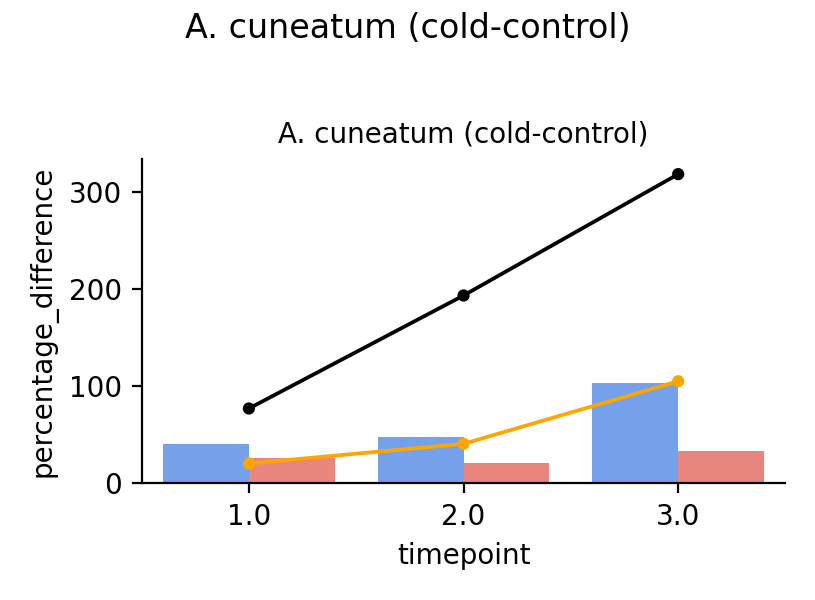

In [120]:
#Aeonium_cun 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
colors = {"morning": "#619CFF", "evening": "#F8766D"}

g = sns.FacetGrid(data=Aeonium_cun, col="species_treatment")
g.map(sns.barplot, "timepoint", "average_FA", "time_of_day", palette=colors, ci=None)  # Set ci=None to remove error bars
g.map(sns.pointplot, "timepoint", "absolute_difference", color="orange", scale=0.5)
g.map(sns.pointplot, "timepoint", "percentage_difference", color="black", scale=0.5)

# Remove the original labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.add_legend(title="Time of day", bbox_to_anchor=(1.05, 1), loc='upper left')
g.fig.suptitle(Aeonium_cun['species_treatment'].unique()[0])
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("graphs/Aeonium/Aeonium_cun.png", bbox_inches='tight', facecolor='white')
plt.show()

/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
/home/joe/.local/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
/home/joe/.local/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
/home/joe/.local/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
/home/joe/.lo

<Figure size 640x480 with 0 Axes>

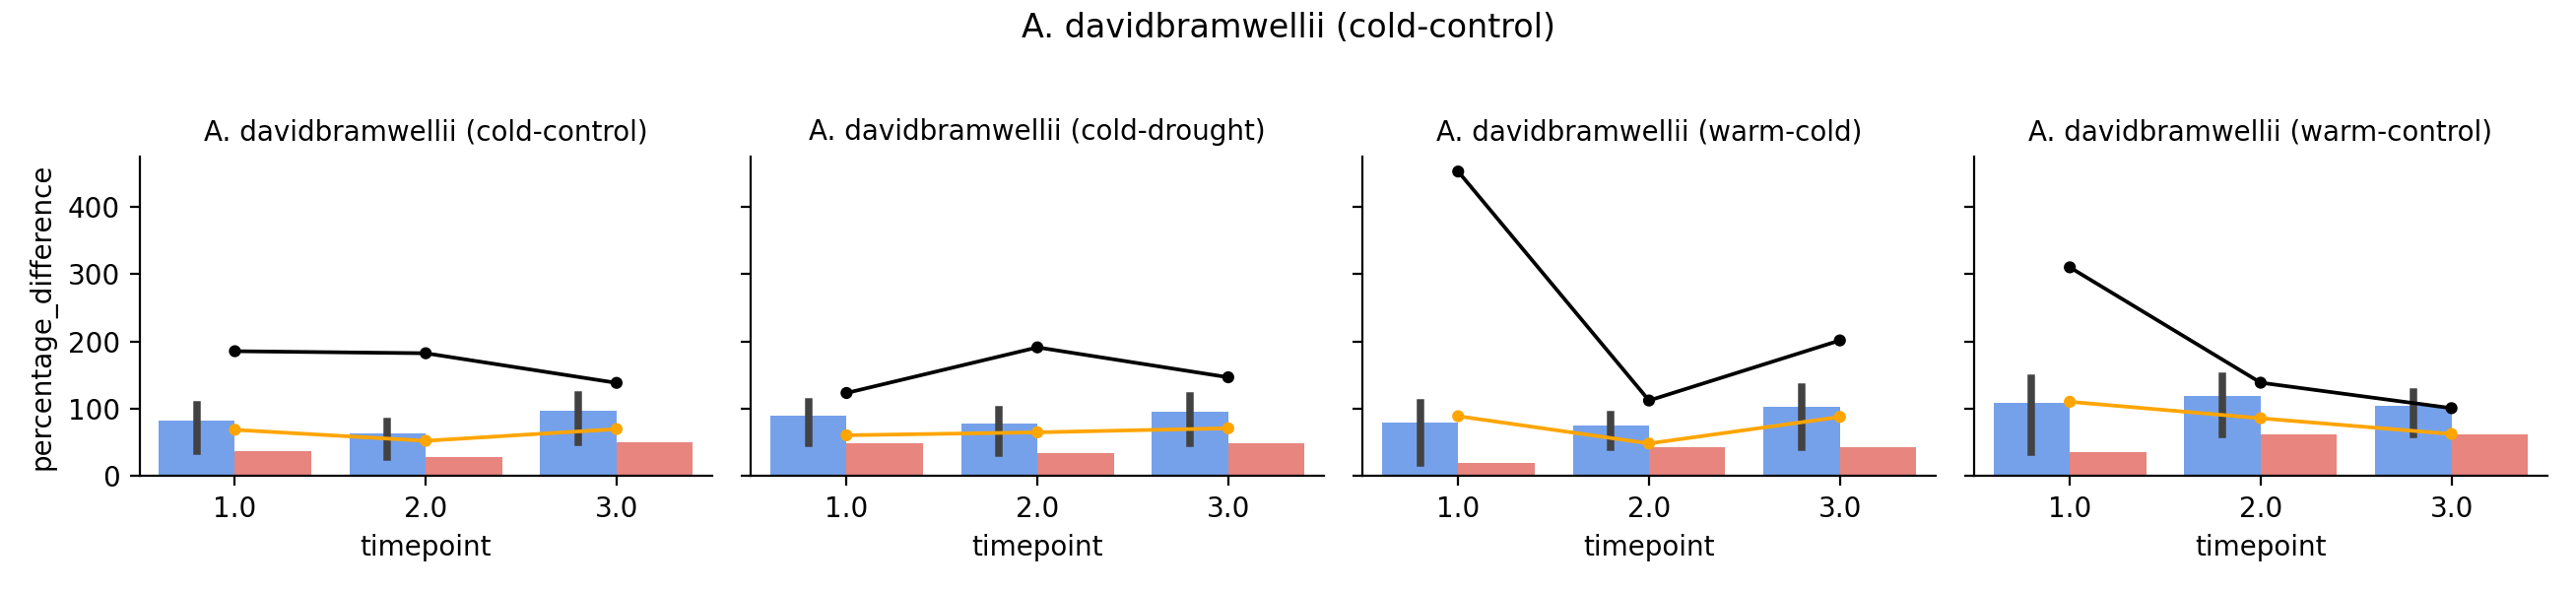

In [122]:
#Aeonium_dav 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
colors = {"morning": "#619CFF", "evening": "#F8766D"}

g = sns.FacetGrid(data=Aeonium_dav, col="species_treatment")
g.map(sns.barplot, "timepoint", "average_FA", "time_of_day", palette=colors, ci=None)  # Set ci=None to remove error bars
g.map(sns.pointplot, "timepoint", "absolute_difference", color="orange", scale=0.5)
g.map(sns.pointplot, "timepoint", "percentage_difference", color="black", scale=0.5)

# Remove the original labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.add_legend(title="Time of day", bbox_to_anchor=(1.05, 1), loc='upper left')
g.fig.suptitle(Aeonium_dav['species_treatment'].unique()[0])
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("graphs/Aeonium/Aeonium_dav.png", bbox_inches='tight', facecolor='white')
plt.show()

In [126]:
#Aeonium_gor 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
colors = {"morning": "#619CFF", "evening": "#F8766D"}

g = sns.FacetGrid(data=Aeonium_gor, col="species_treatment")
g.map(sns.barplot, "timepoint", "average_FA", "time_of_day", palette=colors, ci=None)  # Set ci=None to remove error bars
g.map(sns.pointplot, "timepoint", "absolute_difference", color="orange", scale=0.5)
g.map(sns.pointplot, "timepoint", "percentage_difference", color="black", scale=0.5)

# Remove the original labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.add_legend(title="Time of day", bbox_to_anchor=(1.05, 1), loc='upper left')
g.fig.suptitle(Aeonium_gor['species_treatment'].unique()[0])
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("graphs/Aeonium/Aeonium_gor.png", bbox_inches='tight', facecolor='white')
plt.show()

/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/home/joe/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for th

In [ ]:
#Aeonium_leu 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
colors = {"morning": "#619CFF", "evening": "#F8766D"}

g = sns.FacetGrid(data=Aeonium_leu, col="species_treatment")
g.map(sns.barplot, "timepoint", "average_FA", "time_of_day", palette=colors, ci=None)  # Set ci=None to remove error bars
g.map(sns.pointplot, "timepoint", "absolute_difference", color="orange", scale=0.5)
g.map(sns.pointplot, "timepoint", "percentage_difference", color="black", scale=0.5)

# Remove the original labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.add_legend(title="Time of day", bbox_to_anchor=(1.05, 1), loc='upper left')
g.fig.suptitle(Aeonium_leu['species_treatment'].unique()[0])
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("graphs/Aeonium/Aeonium_leu.png", bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
#Aeonium_per 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
colors = {"morning": "#619CFF", "evening": "#F8766D"}

g = sns.FacetGrid(data=Aeonium_per, col="species_treatment")
g.map(sns.barplot, "timepoint", "average_FA", "time_of_day", palette=colors, ci=None)  # Set ci=None to remove error bars
g.map(sns.pointplot, "timepoint", "absolute_difference", color="orange", scale=0.5)
g.map(sns.pointplot, "timepoint", "percentage_difference", color="black", scale=0.5)

# Remove the original labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.add_legend(title="Time of day", bbox_to_anchor=(1.05, 1), loc='upper left')
g.fig.suptitle(Aeonium_per['species_treatment'].unique()[0])
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("graphs/Aeonium/Aeonium_per.png", bbox_inches='tight', facecolor='white')
plt.show()


In [ ]:
#Aeonium_stu 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
colors = {"morning": "#619CFF", "evening": "#F8766D"}

g = sns.FacetGrid(data=Aeonium_stu, col="species_treatment")
g.map(sns.barplot, "timepoint", "average_FA", "time_of_day", palette=colors, ci=None)  # Set ci=None to remove error bars
g.map(sns.pointplot, "timepoint", "absolute_difference", color="orange", scale=0.5)
g.map(sns.pointplot, "timepoint", "percentage_difference", color="black", scale=0.5)

# Remove the original labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.add_legend(title="Time of day", bbox_to_anchor=(1.05, 1), loc='upper left')
g.fig.suptitle(Aeonium_stu['species_treatment'].unique()[0])
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("graphs/Aeonium/Aeonium_stu.png", bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
#Aeonium_und 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
colors = {"morning": "#619CFF", "evening": "#F8766D"}

g = sns.FacetGrid(data=Aeonium_und, col="species_treatment")
g.map(sns.barplot, "timepoint", "average_FA", "time_of_day", palette=colors, ci=None)  # Set ci=None to remove error bars
g.map(sns.pointplot, "timepoint", "absolute_difference", color="orange", scale=0.5)
g.map(sns.pointplot, "timepoint", "percentage_difference", color="black", scale=0.5)

# Remove the original labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.add_legend(title="Time of day", bbox_to_anchor=(1.05, 1), loc='upper left')
g.fig.suptitle(Aeonium_und['species_treatment'].unique()[0])
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("graphs/Aeonium/Aeonium_und.png", bbox_inches='tight', facecolor='white')
plt.show()